<a href="https://colab.research.google.com/github/vivek-varma/Volatality_Prediction_ML/blob/main/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install xgboost

import os, math, json, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from google.colab import drive

In [2]:
drive.mount('/content/drive', force_remount=False)
DATA_DIR  = "/content/drive/MyDrive/Regime_pred/Data"
OUT_DIR   = "/content/drive/MyDrive/Regime_pred/Models/XGBoost"
os.makedirs(OUT_DIR, exist_ok=True)

Mounted at /content/drive


In [16]:
df = pd.read_csv(f"{DATA_DIR}/REGIME_FEATURES_DAILY_LABELED.csv", parse_dates=["date"]).sort_values("date").reset_index(drop=True)
print("Rows:", len(df), "| Range:", df.date.min().date(), "→", df.date.max().date())
print("Class counts:", df["regime_y"].value_counts().to_dict())

Rows: 3478 | Range: 2018-01-08 → 2024-12-31
Class counts: {2: 1182, 0: 1148, 1: 1148}


In [17]:
drop_cols = ["date", "regime_y", "RV_t1"]               # RV_t1 is derived target; drop to avoid leakage
X = df.drop(columns=[c for c in drop_cols if c in df.columns]).copy()
y = df["regime_y"].astype(int)

In [18]:
obj_cols = X.select_dtypes(include=["object"]).columns
print("Categorical columns:", obj_cols.tolist())
for c in obj_cols:
    X[c] = X[c].astype("category")

Categorical columns: ['level_1']


In [19]:
val_frac = 0.20
val_n = int(math.ceil(len(df) * val_frac))
train_idx = np.arange(0, len(df) - val_n)
val_idx   = np.arange(len(df) - val_n, len(df))

X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
X_val,   y_val   = X.iloc[val_idx],   y.iloc[val_idx]
dates_val = df.iloc[val_idx]["date"].dt.date.values

In [20]:
print(f"Train: {len(X_train)} rows | Val: {len(X_val)} rows")
print(f"Validation period: {df.iloc[val_idx[0]].date.date()} → {df.iloc[val_idx[-1]].date.date()}")

Train: 2782 rows | Val: 696 rows
Validation period: 2023-08-08 → 2024-12-31


In [21]:
classes = np.sort(y_train.unique())
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight_map = {int(c): w for c, w in zip(classes, weights)}
w_train = y_train.map(class_weight_map).values

# ---- XGBoost model ----
xgb = XGBClassifier(
    n_estimators=700,
    max_depth=4,
    learning_rate=0.035,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="multi:softmax",
    num_class=3,
    reg_lambda=2.0,
    random_state=1337,
    n_jobs=-1,
    enable_categorical=True,
    tree_method="hist"
)


In [22]:
xgb.fit(X_train, y_train, sample_weight=w_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.035, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=700,
              n_jobs=-1, num_class=3, ...)

In [23]:
y_pred = xgb.predict(X_val)

In [25]:
bal_acc = balanced_accuracy_score(y_val, y_pred)
f1m     = f1_score(y_val, y_pred, average="macro")
rep     = classification_report(y_val, y_pred, digits=3, zero_division=0)
cm      = confusion_matrix(y_val, y_pred, labels=classes)

print("\n=== Validation Metrics ===")
print("Balanced Accuracy:", round(bal_acc, 4))
print("Macro F1:", round(f1m, 4))
print("\nClassification Report:\n", rep)



=== Validation Metrics ===
Balanced Accuracy: 0.7231
Macro F1: 0.7316

Classification Report:
               precision    recall  f1-score   support

           0      0.832     0.776     0.803       326
           1      0.695     0.797     0.743       266
           2      0.713     0.596     0.649       104

    accuracy                          0.757       696
   macro avg      0.747     0.723     0.732       696
weighted avg      0.762     0.757     0.757       696



In [26]:
model_path   = os.path.join(OUT_DIR, "xgb_model.json")    # portable JSON
feats_path   = os.path.join(OUT_DIR, "xgb_features.json") # to preserve column order
params_path  = os.path.join(OUT_DIR, "xgb_params.json")

xgb.save_model(model_path)

import json
with open(feats_path, "w") as f:
    json.dump(list(X.columns), f, indent=2)
with open(params_path, "w") as f:
    json.dump(xgb.get_params(), f, indent=2)

print("Saved model to:", model_path)

Saved model to: /content/drive/MyDrive/Regime_pred/Models/XGBoost/xgb_model.json


In [27]:
metrics = {"balanced_accuracy": float(bal_acc), "macro_f1": float(f1m), "report": rep}
with open(os.path.join(OUT_DIR, "xgb_val_metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)

pd.DataFrame({"date": dates_val, "y_true": y_val.values, "y_pred": y_pred})\
  .to_csv(os.path.join(OUT_DIR, "xgb_val_predictions.csv"), index=False)

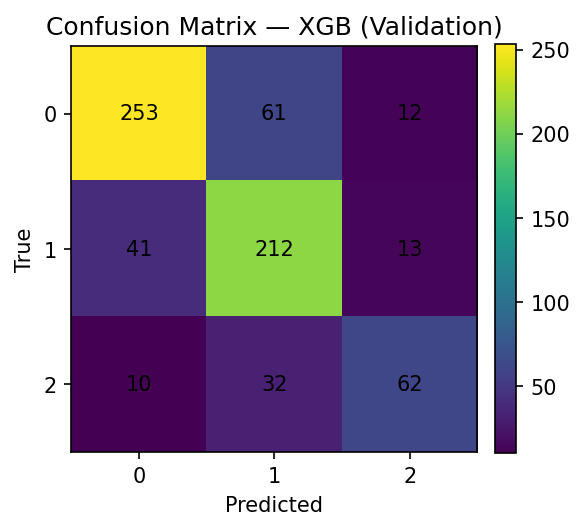

In [28]:
fig, ax = plt.subplots(figsize=(4,4), dpi=150)
im = ax.imshow(cm, interpolation="nearest")
ax.set_title("Confusion Matrix — XGB (Validation)")
ax.set_xticks(range(len(classes))); ax.set_yticks(range(len(classes)))
ax.set_xticklabels(classes); ax.set_yticklabels(classes)
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "xgb_val_confusion_matrix.png"))
plt.show()

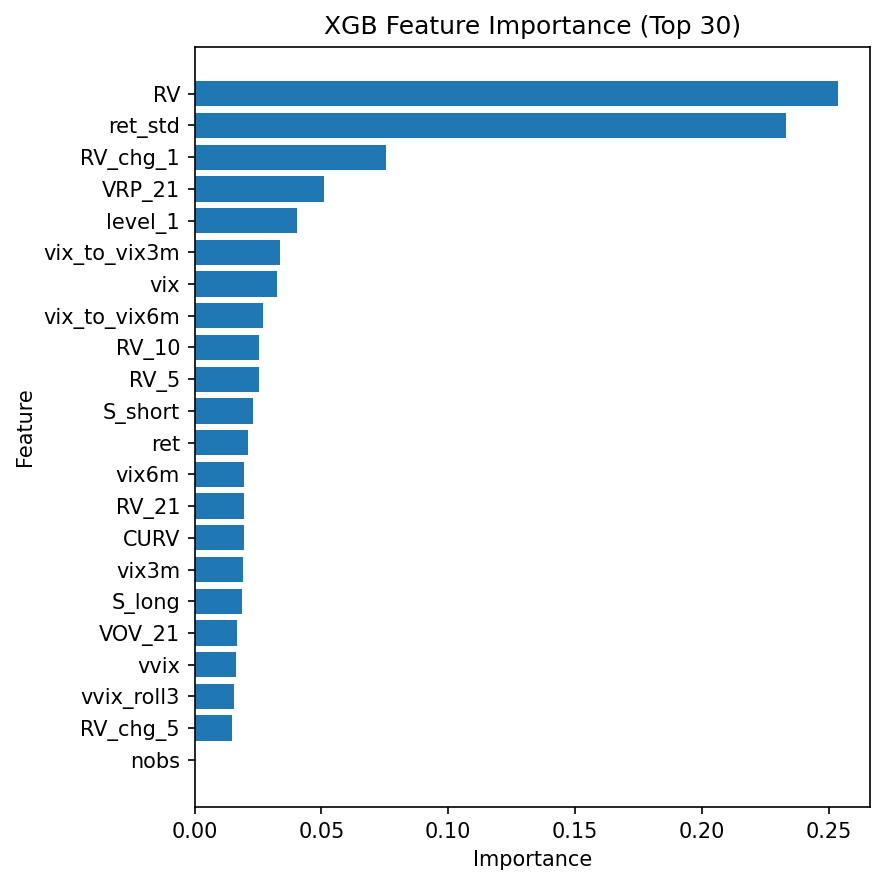


✅ Saved files in: /content/drive/MyDrive/Regime_pred/Models/XGBoost
 - xgb_val_metrics.json
 - xgb_val_predictions.csv
 - xgb_val_confusion_matrix.png
 - xgb_feature_importance.png


In [29]:
try:
    fi = xgb.feature_importances_
    order = np.argsort(fi)[::-1][:30]
    fig, ax = plt.subplots(figsize=(6,6), dpi=150)
    ax.barh(np.array(X.columns)[order][::-1], np.array(fi)[order][::-1])
    ax.set_title("XGB Feature Importance (Top 30)")
    ax.set_xlabel("Importance")
    ax.set_ylabel("Feature")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "xgb_feature_importance.png"))
    plt.show()
except Exception as e:
    print("Feature importance plot skipped:", e)

print(f"\n✅ Saved files in: {OUT_DIR}")
print(" - xgb_val_metrics.json")
print(" - xgb_val_predictions.csv")
print(" - xgb_val_confusion_matrix.png")
print(" - xgb_feature_importance.png")